In [1]:
## This file will evaluate Model_4 

## Model_4 is one of the two sets of models that attempts to truly predict and forecast stock close prices.
## It trains until the end of January, then attempts to predict the first 
## 1, 2, 5, or 10 trading days of February. 

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

In [3]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [5]:
## API Imports 
import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

## FMP Constants 
fmpbase_urlv3 = 'https://fmpcloud.io/api/v3/'
fmpbase_urlv4 = 'https://fmpcloud.io/api/v4/'
api_key = os.getenv("FMP_CLOUD_API_KEY")

start_date = '2022-01-01'
end_date = '2022-01-31'

## FMP Functions 
def get_FMP_historical_data(symbol, startDate=start_date, endDate=end_date, apiKey=api_key):
    url_hist_price = fmpbase_urlv3+'historical-price-full/'
    url_hist_query_with_date = url_hist_price+symbol+'?from='+startDate+'&to='+endDate+'&apikey='+apiKey
    resp_data = requests.get(url_hist_query_with_date)
    json_ = resp_data.json()
    data = json_['historical']
    df = pd.DataFrame(data)
    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.reindex(index=df.index[::-1]) ## Reverse the DataFrame 
    df.set_index('Date',inplace=True)
    df.drop(columns='label',inplace=True)
    return df

In [6]:
import datetime

def get_data_updated(symbol,n_days):
    import_path = Path('../FilesExport_Updated_DFs_01_31/'+symbol+'_ti_df_no_ftd.pkl')
    data = load_obj(import_path)
    import_df = data[symbol]
    
    #df - import_df.copy()

    df_close = import_df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})    
    
    features_df = import_df.reset_index().drop(columns=['close','adjClose'])
    
    new_close_df = df_close.iloc[n_days: , :].reset_index(drop=True)
    
    last_date = new_close_df.iloc[-1]['Close_Date']
    last_price = new_close_df.iloc[-1]['close']

    for i in range(n_days):
        if i == 0:
            next_date = last_date + datetime.timedelta(days=1)
            if next_date.weekday() == 5:
                next_date = next_date + datetime.timedelta(days=2)
            d = {'Close_Date': [last_date], 'close': [last_price]}
            df1 = pd.DataFrame(data=d)
            

        else:
            next_date = next_date + datetime.timedelta(days=1)

            if next_date.weekday() == 5:
                next_date = next_date + datetime.timedelta(days=2)

            d2 = {'Close_Date': [next_date], 'close': [last_price]}
            df2 = pd.DataFrame(data=d2)

        ## Append to df1
            df1 = df1.append(df2,ignore_index=True)

    new_close_df = new_close_df.append(df1,ignore_index=True)
    
    return features_df, new_close_df

## Prepare Data for ML
def prepare_data_updated(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data_updated(symbol,n_days)
    
    X = features_df.drop(columns={'Date'}).values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y

In [7]:
x_df, y_df = get_data_updated('GME',5)

In [8]:
y_df

,Close_Date,close
0,2016-03-09,31.290001
1,2016-03-10,30.440001
2,2016-03-11,30.750000
3,2016-03-14,31.660000
4,2016-03-15,30.780001
...,...,...
1486,2022-01-31,108.930000
1487,2022-02-02,108.930000
1488,2022-02-03,108.930000
1489,2022-02-04,108.930000


In [9]:
## Import symbol_accuracy_dict
path = Path('../Resources/Feb2022_symbol_accuracy_dict.pkl')
symbol_accuracy_dict = load_obj(path)
len(symbol_accuracy_dict)

3068

In [10]:
len(symbol_accuracy_dict) / 4

767.0

In [11]:
## Put into DF
symbol_accuracy_df = pd.DataFrame.from_dict(symbol_accuracy_dict,orient='index')
symbol_accuracy_df

,model_accuracy,n_days
AAL_1,1.005525,1
AAL_2,1.990746,2
AAL_5,3.858438,5
AAL_10,7.194328,10
AAU_1,0.001576,1
...,...,...
ZROZ_10,25.287083,10
ZYNE_1,0.386303,1
ZYNE_2,0.619263,2
ZYNE_5,1.142342,5


In [12]:
n_days = 10

acc_df = symbol_accuracy_df[symbol_accuracy_df["n_days"].isin([n_days])]
acc_df.sort_values('model_accuracy').head(10)

,model_accuracy,n_days
XPL_10,0.002958,10
DHY_10,0.003600,10
AUMN_10,0.003715,10
CPHI_10,0.005113,10
UAMY_10,0.005323,10
MSN_10,0.007071,10
KIQ_10,0.008040,10
VGZ_10,0.008749,10
AAU_10,0.010365,10
GPL_10,0.010849,10


<AxesSubplot:xlabel='Close_Date'>

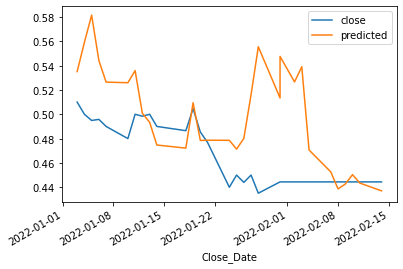

In [17]:
symbol = 'XPL'

n_days = 10
model_type = 'NN'

n_days_string = str(n_days)

import_path='../Model_Data/Feb2022_NN_models/Low_Acc/'
import_path_prefix = import_path+symbol+'_'+model_type+'_'+n_days_string

file_path = Path(import_path_prefix+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# load weights into new model
file_path = Path(import_path_prefix+'_model_weights.h5')
loaded_model.load_weights(file_path)

X, y, features_df, close_df = prepare_data_updated(symbol,n_days,return_data=True)

X = features_df.drop(columns={'Date'}).values
#y = close_df['close'].values

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

close_df["predicted"] = loaded_model.predict(X)
close_df.set_index('Close_Date',inplace=True)
close_df[['close','predicted']].tail(30).plot(use_index=True)

In [18]:
def load_model_and_predict_model(symbol,n_days):
    model_type = 'NN'

    n_days_string = str(n_days)

    import_path='../Model_Data/Feb2022_NN_models/Low_Acc/'
    import_path_prefix = import_path+symbol+'_'+model_type+'_'+n_days_string

    file_path = Path(import_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model = model_from_json(model_json)

    # load weights into new model
    file_path = Path(import_path_prefix+'_model_weights.h5')
    loaded_model.load_weights(file_path)
    
    ## Load model summary
    file_path = Path(import_path_prefix+'_model_summary.pkl')
    model_summary = load_obj(file_path)

    X, y, features_df, close_df = prepare_data_updated(symbol,n_days,return_data=True)

    X = features_df.drop(columns={'Date'}).values
    #y = close_df['close'].values

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    close_df["predicted"] = loaded_model.predict(X)
    close_df.set_index('Close_Date',inplace=True)
    
    predicted_df = close_df[['close','predicted']]
    
    return loaded_model, model_summary, predicted_df

In [19]:
model, summary, pred_df = load_model_and_predict_model('GME',10)

In [21]:
summary['model_accuracy']

366.01068115234375

In [14]:
for col in features_df.columns:
    print(col)

Date
open
high
low
volume
unadjustedVolume
change
changePercent
vwap
changeOverTime
ShortVolumeNSDQ
ShortExemptVolumeNSDQ
TotalVolumeNSDQ
ShortVolumeNYSE
ShortExemptVolumeNYSE
TotalVolumeNYSE
bollinger_signal
dema_signal
adl_signal
rsi_signal


In [15]:
close_df

,close,predicted
Close_Date,,
2016-03-03,0.5100,0.520927
2016-03-04,0.5200,0.526000
2016-03-07,0.5000,0.531349
2016-03-08,0.4900,0.518351
2016-03-09,0.4900,0.501473
...,...,...
2022-01-26,0.4440,0.447969
2022-01-27,0.4500,0.444073
2022-01-28,0.4351,0.454210


In [16]:
NN_symbol_acc_dict_path = '../Resources/Feb_NN_symbol_acc_dict.pkl'
NN_symbol_acc_dict = {}